In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Attention, GRU
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ------------------------------- #
# Load and Preprocess Training Data
# ------------------------------- #

# Load dataset
df = pd.read_csv("cleaned_data.csv")

# Define the starting year (adjust this based on the dataset)
base_year = 2010  # If Year 1 corresponds to 2016

# Convert Year values
df['Year'] = df['Year'] + base_year

# Ensure Month and Day are correctly formatted
df['Month'] = df['Month'].astype(str).str.zfill(2)
df['Day'] = df['Day'].astype(str).str.zfill(2)

# Convert to proper datetime format
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

print(df.head())  # Check the output


# Convert Year, Month, Day to datetime
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Drop unnecessary columns
df = df.drop(columns=['ID', 'kingdom', 'Year', 'Month', 'Day'])

# Sort by date
df = df.sort_values(by='date').reset_index(drop=True)

# Normalize numerical features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['date']))

# Convert to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=df.columns[1:])

# ------------------------------- #
# Create Time Series Sequences
# ------------------------------- #
TIME_STEPS = 30   # Past 30 days as input
PREDICT_HORIZON = 1  # Predicting 1 day ahead

def create_sequences(data, time_steps=TIME_STEPS, predict_horizon=PREDICT_HORIZON):
    X, y = [], []
    for i in range(len(data) - time_steps - predict_horizon):
        X.append(data.iloc[i: i + time_steps].values)
        y.append(data.iloc[i + time_steps + predict_horizon - 1, 0])  # Predicting Avg_Temperature
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(scaled_df)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_data.csv'

In [ ]:
# AFTER CHANGING BY ISITHA
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Attention, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load Dataset
df = pd.read_csv("cleaned_data.csv")

# Sorting
df.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

# One-hot Encoding
df = pd.get_dummies(df, columns=['kingdom'], drop_first=True)

# Select Features & Targets
X = df[['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
Y = df[['Avg_Temperature','Radiation', 'Rain_Amount','Wind_Speed', 'Wind_Direction']].values

# Normalize Features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Prepare Sequential Data
time_steps = 30
X_seq, Y_seq = [], []

for i in range(len(X) - time_steps):
    X_seq.append(X[i:i+time_steps])
    Y_seq.append(Y[i+time_steps])

X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

# Train-Test Split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

In [ ]:
# ------------------------------- #
# Build CNN-LSTM-Attention Model
# ------------------------------- #

# Define model input
input_layer = Input(shape=(TIME_STEPS, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# LSTM Layer
lstm_layer = LSTM(50, return_sequences=True)(input_layer)

# Attention Layer
attention_layer = Attention()([lstm_layer, lstm_layer])
attention_output = Flatten()(attention_layer)

# Merge CNN and LSTM outputs
merged = tf.keras.layers.Concatenate()([flatten, attention_output])

# Dense Layers
dense1 = Dense(64, activation='relu')(merged)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(1)(dense2)  # Predicting Avg_Temperature

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 30, 32)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 30, 64)         │          6,208 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 15, 64)         │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 15, 32)         │          6,176 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 30, 50)         │         16,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 7, 32)          │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention (Attention)     │ (None, 30, 50)         │              0 │ lstm[0][0], lstm[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 224)            │              0 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1500)           │              0 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1724)           │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │        110,400 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             33 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 141,497 (552.72 KB)

 Trainable params: 141,497 (552.72 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ------------------------------- #
# Build CNN-GRU-Attention Model
# ------------------------------- #

# Define model input
input_layer = Input(shape=(TIME_STEPS, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# GRU Layer
gru_layer = GRU(50, return_sequences=True)(input_layer)

# Attention Layer
attention_layer = Attention()([gru_layer, gru_layer])
attention_output = Flatten()(attention_layer)

# Merge CNN and GRU outputs
merged = tf.keras.layers.Concatenate()([flatten, attention_output])

# Dense Layers
dense1 = Dense(64, activation='relu')(merged)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(1)(dense2)  # Predicting Avg_Temperature

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 30, 32)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 30, 64)         │          6,208 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 15, 64)         │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 15, 32)         │          6,176 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 30, 50)         │         12,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 7, 32)          │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_1 (Attention)   │ (None, 30, 50)         │              0 │ gru[0][0], gru[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 224)            │              0 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 1500)           │              0 │ attention_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1724)           │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │        110,400 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          2,080 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │             33 │ dense_4[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 137,497 (537.10 KB)

 Trainable params: 137,497 (537.10 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ------------------------------- #
# Train the Model
# ------------------------------- #
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# ------------------------------- #
# Prepare Test Data for Prediction
# ------------------------------- #

# Load test data
test_df = pd.read_csv("../test.csv")

# Convert Year, Month, Day to datetime
test_df['date'] = pd.to_datetime(test_df[['Year', 'Month', 'Day']])

# Drop unnecessary columns
test_df = test_df.drop(columns=['ID', 'kingdom', 'Year', 'Month', 'Day'])

# Merge with last known training data (to get missing feature values)
last_train_data = df[df['date'] <= test_df['date'].min()]  # Get last available data
test_df = test_df.merge(last_train_data, on='date', how='left')

# Fill missing values using forward fill
test_df.fillna(method='ffill', inplace=True)

# Normalize test data
scaled_test_data = scaler.transform(test_df.drop(columns=['date']))

# Convert test data into sequences
X_test_seq, _ = create_sequences(pd.DataFrame(scaled_test_data, columns=test_df.columns[1:]))

# ------------------------------- #
# Make Predictions
# ------------------------------- #
predictions = model.predict(X_test_seq)

# Convert predictions back to original scale
predicted_temp = scaler.inverse_transform(predictions)

# Save predictions
test_df['Predicted_Temperature'] = predicted_temp
test_df.to_csv("predictions.csv", index=False)

print("Predictions saved successfully!")


Epoch 1/30
 180/2124 ━━━━━━━━━━━━━━━━━━━━ 2:05 65ms/step - loss: 8684.2090 - mae: 61.7630

KeyboardInterrupt: 

In [ ]:
# Load test data
test_df = pd.read_csv("C:\\Users\\Isitha\\Downloads\\test.csv")


# Define the starting year (adjust this based on the dataset)
base_year = 2010  # If Year 1 corresponds to 2016

# Convert Year values
test_df['Year'] = test_df['Year'] + base_year

# Ensure Month and Day are correctly formatted
test_df['Month'] = test_df['Month'].astype(str).str.zfill(2)
test_df['Day'] = test_df['Day'].astype(str).str.zfill(2)

# Convert to proper datetime format
test_df['date'] = pd.to_datetime(test_df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

print(test_df.head())  # Check the output

# Convert Year, Month, Day to datetime
test_df['date'] = pd.to_datetime(test_df[['Year', 'Month', 'Day']])

# Drop unnecessary columns
test_df = test_df.drop(columns=['ID', 'kingdom', 'Year', 'Month', 'Day'])

# Merge with last known training data (to get missing feature values)
last_train_data = df[df['date'] <= test_df['date'].min()]  # Get last available data
test_df = test_df.merge(last_train_data, on='date', how='left')

# Fill missing values using forward fill
test_df.fillna(method='ffill', inplace=True)

# Normalize test data
scaled_test_data = scaler.transform(test_df.drop(columns=['date']))

# Convert test data into sequences
X_test_seq, _ = create_sequences(pd.DataFrame(scaled_test_data, columns=test_df.columns[1:]))



# ------------------------------- #
# Make Predictions
# ------------------------------- #
predictions = model.predict(X_test_seq)

# Convert predictions back to original scale
predicted_temp = scaler.inverse_transform(predictions)

# Save predictions
test_df['Predicted_Temperature'] = predicted_temp
test_df.to_csv("predictions.csv", index=False)

print("Predictions saved successfully!")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming you already have your trained model and scaler
# Load the test data
test_df = pd.read_csv("C:\\Users\\Isitha\\Downloads\\test.csv")

# Map the Year column (1-8) to actual years (e.g., 2016 to 2023)
base_year = 2015  # If Year 1 corresponds to 2016
test_df['Year'] = test_df['Year'] + base_year

# Ensure Month and Day are in proper format
test_df['Month'] = test_df['Month'].astype(str).str.zfill(2)
test_df['Day'] = test_df['Day'].astype(str).str.zfill(2)

# Create the date column
test_df['date'] = pd.to_datetime(test_df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))

# Drop unnecessary columns (those not used for prediction)
test_df = test_df.drop(columns=['ID', 'Year', 'Month', 'Day', 'kingdom', 'date'])

# Ensure columns in the test data match those in the training data
required_columns = ['Avg_Temperature', 'Avg_Feels_Like_Temperature', 'Temperature_Range',
                    'Feels_Like_Temperature_Range', 'Radiation', 'Rain_Amount', 'Rain_Duration',
                    'Wind_Speed', 'Wind_Direction', 'Evapotranspiration']  # Add the exact list from training
missing_columns = [col for col in required_columns if col not in test_df.columns]

if missing_columns:
    raise ValueError(f"Missing columns in test data: {missing_columns}")

# Check for extra columns in test data
extra_columns = [col for col in test_df.columns if col not in required_columns]
if extra_columns:
    print(f"Warning: Extra columns in test data that are not used for prediction: {extra_columns}")
    test_df = test_df[required_columns]  # Remove extra columns

# Normalize the test data using the same scaler used during training
scaled_test_data = scaler.transform(test_df)

# Convert test data into sequences (same as for training)
X_test_seq, _ = create_sequences(pd.DataFrame(scaled_test_data, columns=test_df.columns))

# Predict using the trained model
predictions = model.predict(X_test_seq)

# If you need to inverse the scaling
predicted_values = scaler.inverse_transform(predictions)

# You can extract the predicted values for each of the variables
predicted_temp = predicted_values[:, 0]  # Assuming temperature is the first column in your predictions

# Adding predictions to the test DataFrame (you can add other variables similarly)
test_df['Predicted_Temperature'] = predicted_temp

# Optionally, save the predictions to a CSV
test_df.to_csv('predictions.csv', index=False)

# Print the first few rows of the predictions
print(test_df.head())


Finding corelations in the dataset

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data into a pandas DataFrame
data = pd.read_csv('./train.csv')  # Replace with the actual path to your data file

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

# Basic statistics of the dataset
print("\nBasic statistics of the dataset:")
print(data.describe())

# Check for missing values
print("\nMissing values in the dataset:")
print(data.isnull().sum())

def kelvin_to_celsius(kelvin_temp):
    """Converts temperature in Kelvin to Celsius.
    Args:
        kelvin_temp: Temperature in Kelvin.
    Returns:
        Temperature in Celsius.
    """
    celsius_temp = kelvin_temp - 273.15
    return celsius_temp

# Assume 'df' is your DataFrame and 'Avg_Temperature' is the column
# Replace outlier_condition with your logic to identify Kelvin values
data['Avg_Temperature'] = np.where(data['Avg_Temperature'] > 270,
                                      data['Avg_Temperature'].apply(kelvin_to_celsius),
                                      data['Avg_Temperature'])

# Visualize the distribution of Avg_Temperature
plt.figure(figsize=(10, 6))
sns.histplot(data['Avg_Temperature'], kde=True, color='blue')
plt.title('Distribution of Avg_Temperature')
plt.xlabel('Avg_Temperature')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of Radiation
plt.figure(figsize=(10, 6))
sns.histplot(data['Radiation'], kde=True, color='blue')
plt.title('Distribution of Radiation')
plt.xlabel('Radiation')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of Rain_Amount
plt.figure(figsize=(10, 6))
sns.histplot(data['Rain_Amount'], kde=True, color='blue')
plt.title('Distribution of Rain_Amount')
plt.xlabel('Rain_Amount')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of Wind_Speed
plt.figure(figsize=(10, 6))
sns.histplot(data['Wind_Speed'], kde=True, color='blue')
plt.title('Distribution of Wind_Speed')
plt.xlabel('Wind_Speed')
plt.ylabel('Frequency')
plt.show()

# Visualize the distribution of Wind_Direction
plt.figure(figsize=(10, 6))
sns.histplot(data['Wind_Direction'], kde=True, color='blue')
plt.title('Distribution of Wind_Direction')
plt.xlabel('Wind_Direction')
plt.ylabel('Frequency')
plt.show()


# Scatter plot for Avg_Temperature vs Radiation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Avg_Temperature', y='Radiation', hue='kingdom', data=data)
plt.title('Avg_Temperature vs Radiation')
plt.xlabel('Avg_Temperature')
plt.ylabel('Radiation')
plt.legend(title='Kingdom')
plt.show()



# Correlation heatmap
plt.figure(figsize=(12, 8))

# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Boxplot for Avg_Temperature by Kingdom
plt.figure(figsize=(12, 6))
sns.boxplot(x='kingdom', y='Avg_Temperature', data=data)
plt.title('Avg_Temperature by Kingdom')
plt.xlabel('Kingdom')
plt.ylabel('Avg_Temperature')
plt.xticks(rotation=45)
plt.show()

# Pairplot for selected features
selected_features = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed']
sns.pairplot(data[selected_features])
plt.show()

data.hist(bins=50, figsize=(12, 8))
plt.show()

data.plot(kind="scatter", x="longitude", y="latitude", grid=True,
s=data["Avg_Temperature"]/100 , label="temperature" ,c=data["Avg_Temperature"], cmap="jet", colorbar=True,legend=True, sharex=False, figsize=(10, 7))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './train.csv'

In [ ]:
data.plot(kind="scatter", x="longitude", y="latitude", grid=True,
s=data["Avg_Temperature"] , label="temperature" ,c=data["Avg_Temperature"], cmap="jet", colorbar=True,legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [ ]:
data.to_csv('cleaned_data.csv', index=False)
print("\nCleaned data saved to 'cleaned_data.csv'")

In [ ]:
3# prompt: Write me a code to generate time series graphs for each kingdom using python and matplotlib
# Date is in 3 columns as (Year         Month           Day)
# I said there isn't a column called Date. instead of it there are three columns as year, month, day

import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("cleaned_data.csv")  # Replace with your actual file path

# Convert Year, Month, Day to datetime
# Convert Year, Month, Day to datetime
df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1))
# Group data by kingdom and date

kingdom_groups = df.groupby('kingdom')

# Iterate through each kingdom
for kingdom, data in kingdom_groups:
    # Sort the data by date

    data = data.sort_values(by='date')

    # Plot the time series for Avg_Temperature
    plt.figure(figsize=(10, 6))
    plt.plot(data['date'], data['Rain_Duration'])
    plt.title(f'Average Temperature over Time for Kingdom: {kingdom}')
    plt.xlabel('Date')
    plt.ylabel('Average Temperature')
    plt.xticks(rotation=45)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, Attention, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load Dataset
df = pd.read_csv("cleaned_data.csv")

# Sorting
df.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

# One-hot Encoding
df = pd.get_dummies(df, columns=['kingdom'], drop_first=True)

# Select Features & Targets
X = df[['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
Y = df[['Avg_Temperature','Radiation', 'Rain_Amount','Wind_Speed', 'Wind_Direction']].values

# Normalize Features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Prepare Sequential Data
time_steps = 30
X_seq, Y_seq = [], []

for i in range(len(X) - time_steps):
    X_seq.append(X[i:i+time_steps])
    Y_seq.append(Y[i+time_steps])

X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

# Train-Test Split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# ------------------------------- #
# Build CNN-LSTM-Attention Model
# ------------------------------- #

# Model Input
input_layer = Input(shape=(time_steps, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
cnn_output = Flatten()(pool2)

# LSTM Layer
lstm_layer = LSTM(50, return_sequences=True)(input_layer)

# Attention Layer
attention_layer = Attention()([lstm_layer, lstm_layer])
attention_output = GlobalAveragePooling1D()(attention_layer)

# Merge CNN and LSTM outputs
merged = Concatenate()([cnn_output, attention_output])

# Dense Layers
dense1 = Dense(64, activation='relu')(merged)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(5)(dense2)  # Predicting 5 variables

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()

# ------------------------------- #
# Train the Model
# ------------------------------- #
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load Dataset
df1 = pd.read_csv("cleaned_data.csv")

# Sorting
df1.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

# One-hot Encoding
df = pd.get_dummies(df1, columns=['kingdom'], drop_first=True)  # This removes the 'kingdom' column

# Define Time Steps
time_steps = 30

# Store sequences
X_seq, Y_seq = [], []

# Group by Kingdom using df1 (original)
for kingdom, group in df1.groupby('kingdom'):
    # Get corresponding rows from df (one-hot encoded)
    group_X = df.loc[group.index, ['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
    group_Y = group.loc[:, ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']].values

    # Normalize Features
    scaler_X = MinMaxScaler()
    group_X = scaler_X.fit_transform(group_X)

    scaler_Y = MinMaxScaler()
    group_Y = scaler_Y.fit_transform(group_Y)

    # Generate Time-Series Sequences for This Kingdom
    for i in range(len(group_X) - time_steps):
        X_seq.append(group_X[i:i+time_steps])
        Y_seq.append(group_Y[i+time_steps])

# Convert to numpy arrays
X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

# Train-Test Split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# Print Shape for Debugging
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


# ------------------------------- #
# Build CNN-LSTM-Attention Model
# ------------------------------- #

# Model Input
input_layer = Input(shape=(time_steps, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
cnn_output = Flatten()(pool2)

# LSTM Layer
lstm_layer = LSTM(50, return_sequences=True)(input_layer)

# Attention Layer
attention_layer = Attention()([lstm_layer, lstm_layer])
attention_output = GlobalAveragePooling1D()(attention_layer)

# Merge CNN and LSTM outputs
merged = Concatenate()([cnn_output, attention_output])

# Dense Layers
dense1 = Dense(64, activation='relu')(merged)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(5)(dense2)  # Predicting 5 variables

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Model Summary
model.summary()

# ------------------------------- #
# Train the Model
# ------------------------------- #
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load Dataset
df1 = pd.read_csv("cleaned_data.csv")

# Sorting
df1.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

# One-hot Encoding
df = pd.get_dummies(df1, columns=['kingdom'], drop_first=True)  # This removes the 'kingdom' column

# Define Time Steps
time_steps = 30

# Store sequences
X_seq, Y_seq = [], []

# Group by Kingdom using df1 (original)
for kingdom, group in df1.groupby('kingdom'):
    # Get corresponding rows from df (one-hot encoded)
    group_X = df.loc[group.index, ['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
    group_Y = group.loc[:, ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']].values

    # Normalize Features
    scaler_X = MinMaxScaler()
    group_X = scaler_X.fit_transform(group_X)

    scaler_Y = MinMaxScaler()
    group_Y = scaler_Y.fit_transform(group_Y)

    # Generate Time-Series Sequences for This Kingdom
    for i in range(len(group_X) - time_steps):
        X_seq.append(group_X[i:i+time_steps])
        Y_seq.append(group_Y[i+time_steps])

# Convert to numpy arrays
X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

# Train-Test Split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# Print Shape for Debugging
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


# ------------------------------- #
# Build CNN-GRU-Attention Model
# ------------------------------- #

# Define model input
input_layer = Input(shape=(TIME_STEPS, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
flatten = Flatten()(pool2)

# GRU Layer
gru_layer = GRU(50, return_sequences=True)(input_layer)

# Attention Layer
attention_layer = Attention()([gru_layer, gru_layer])
attention_output = Flatten()(attention_layer)

# Merge CNN and GRU outputs
merged = tf.keras.layers.Concatenate()([flatten, attention_output])

# Dense Layers
dense1 = Dense(64, activation='relu')(merged)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(1)(dense2)  # Predicting Avg_Temperature

# Build Model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Summary
model.summary()

# ------------------------------- #
# Train the Model
# ------------------------------- #
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Load Dataset
df1 = pd.read_csv("cleaned_data.csv")

# Sorting
df1.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

# One-hot Encoding
df = pd.get_dummies(df1, columns=['kingdom'], drop_first=True)  # This removes the 'kingdom' column

# Define Time Steps
time_steps = 30

# Store sequences
X_seq, Y_seq = [], []

# Group by Kingdom using df1 (original)
for kingdom, group in df1.groupby('kingdom'):
    # Get corresponding rows from df (one-hot encoded)
    group_X = df.loc[group.index, ['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
    group_Y = group.loc[:, ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']].values

    # Normalize Features
    scaler_X = MinMaxScaler()
    group_X = scaler_X.fit_transform(group_X)

    scaler_Y = MinMaxScaler()
    group_Y = scaler_Y.fit_transform(group_Y)

    # Generate Time-Series Sequences for This Kingdom
    for i in range(len(group_X) - time_steps):
        X_seq.append(group_X[i:i+time_steps])
        Y_seq.append(group_Y[i+time_steps])

# Convert to numpy arrays
X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

# Train-Test Split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# Print Shape for Debugging
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


# ------------------------------- #
# Build Transformer Model
# ------------------------------- #

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    # Attention layer
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + inputs)  # Skip Connection

    # Feed-Forward Network
    ff_output = tf.keras.layers.Dense(ff_dim, activation='relu')(attn_output)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)  # Output size matching input
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attn_output)


# Model Input
input_layer = Input(shape=(time_steps, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(pool1)

# Calculate the new time dimension after pooling
new_time_steps = time_steps // 2  # 30 / 2 = 15

# Reshaping to match transformer input shape (batch_size, time_steps, feature_size)
transformer_input = tf.keras.layers.Reshape((new_time_steps, conv2.shape[-1]))(conv2)

# Transformer Encoder
transformer_output = transformer_encoder(transformer_input, head_size=64, num_heads=4, ff_dim=128)

# Flatten the transformer output
flatten = Flatten()(transformer_output)

# Dense Layers
dense1 = Dense(64, activation='relu')(flatten)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(5)(dense2)  # Adjusted to match y_train.shape[-1]

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])
# Model Summary
model.summary()

# ------------------------------- #
# Train the Model
# ------------------------------- #
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Attention, Dense, Dropout, Flatten, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import xgboost as xgb
# Load Dataset
df1 = pd.read_csv("cleaned_data.csv")

# Sorting
df1.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

# One-hot Encoding
df = pd.get_dummies(df1, columns=['kingdom'], drop_first=True)

# Define Time Steps
time_steps = 30

# Store sequences and data for Decision Trees
X_seq, Y_seq = [], []
X_dt_dict, Y_dt_dict = {}, {}  # Dictionary to store data per kingdom for Decision Trees

# Group by Kingdom
for kingdom, group in df1.groupby('kingdom'):
    # Get corresponding rows from df (one-hot encoded)
    group_X = df.loc[group.index, ['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
    group_Y = group.loc[:, ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']].values

    # Normalize Features
    scaler_X = MinMaxScaler()
    group_X_scaled = scaler_X.fit_transform(group_X)

    scaler_Y = MinMaxScaler()
    group_Y_scaled = scaler_Y.fit_transform(group_Y)

    # Generate Time-Series Sequences for CNN-LSTM-Attention
    for i in range(len(group_X_scaled) - time_steps):
        X_seq.append(group_X_scaled[i:i+time_steps])
        Y_seq.append(group_Y_scaled[i+time_steps])

    # Store data for Decision Tree (no sequences, just flat data)
    X_dt_dict[kingdom] = group_X_scaled
    Y_dt_dict[kingdom] = group_Y_scaled

# Convert to numpy arrays for CNN-LSTM
X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

# Train-Test Split for CNN-LSTM
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# Print Shape for Debugging
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# ------------------------------- #
# Build Transformer Model
# ------------------------------- #

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    # Attention layer
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + inputs)  # Skip Connection

    # Feed-Forward Network
    ff_output = tf.keras.layers.Dense(ff_dim, activation='relu')(attn_output)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)  # Output size matching input
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attn_output)


# Model Input
input_layer = Input(shape=(time_steps, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(pool1)

# Calculate the new time dimension after pooling
new_time_steps = time_steps // 2  # 30 / 2 = 15

# Reshaping to match transformer input shape (batch_size, time_steps, feature_size)
transformer_input = tf.keras.layers.Reshape((new_time_steps, conv2.shape[-1]))(conv2)

# Transformer Encoder
transformer_output = transformer_encoder(transformer_input, head_size=64, num_heads=4, ff_dim=128)

# Flatten the transformer output
flatten = Flatten()(transformer_output)

# Dense Layers
dense1 = Dense(64, activation='relu')(flatten)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(5)(dense2)  # Adjusted to match y_train.shape[-1]

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])
# Model Summary
model.summary()

# ------------------------------- #
# Decision Tree Models per Kingdom
# ------------------------------- #

# Dictionary to store Decision Tree models and their performance
dt_models = {}
dt_mae_scores = {}

for kingdom in X_dt_dict.keys():
    # Train-test split for XGBoost (80-20 split)
    X_dt = X_dt_dict[kingdom]
    Y_dt = Y_dt_dict[kingdom]
    split_dt = int(0.8 * len(X_dt))

    X_dt_train, X_dt_test = X_dt[:split_dt], X_dt[split_dt:]
    y_dt_train, y_dt_test = Y_dt[:split_dt], Y_dt[split_dt:]

    # Initialize and train XGBoost Regressor

    # xgb_model.fit(X_dt_train, y_dt_train)
    history_dt = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

    # Store the model
    dt_models[kingdom] = history_dt

    # Evaluate the model
    # y_dt_pred = xgb_model.predict(X_dt_test)
    # mae = np.mean(np.abs(y_dt_test - y_dt_pred))
    # xgb_mae_scores[kingdom] = mae
    print(f"XGBoost MAE for {kingdom}: {mae}")
    plt.plot(history.history['loss'], label='Train Loss (CNN-LSTM)')
    plt.plot(history.history['val_loss'], label='Validation Loss (CNN-LSTM)')
    plt.legend()
    plt.title(f"CNN-LSTM-Attention Training Loss for {kingdom}")
    plt.show()


# ------------------------------- #
# Plot CNN-LSTM-Attention Results
# ------------------------------- #

# plt.plot(history.history['loss'], label='Train Loss (CNN-LSTM)')
# plt.plot(history.history['val_loss'], label='Validation Loss (CNN-LSTM)')
# plt.legend()
# plt.title("CNN-LSTM-Attention Training Loss")
# plt.show()

# ------------------------------- #
# Compare Results
# ------------------------------- #

# print("\nCNN-LSTM-Attention Validation MAE:", history.history['mae'][-1])
print("Decision Tree MAE Scores per Kingdom:")
for kingdom, mae in xgb_mae_scores.items():
    print(f"{kingdom}: {mae}")

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load Dataset
df = pd.read_csv("cleaned_data.csv")

# Convert Year, Month, and Day into a Date column (required for Prophet)
df['ds'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
target_columns = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']

# Dictionary to store Prophet models and forecasts for each kingdom
prophet_models = {}
prophet_forecasts = {}

# Train a separate Prophet model for each kingdom and each target variable
for kingdom, group in df.groupby('kingdom'):
    prophet_models[kingdom] = {}
    prophet_forecasts[kingdom] = {}

    for target in target_columns:
        print(f"Training Prophet model for {kingdom} - {target}...")

        # Prepare data for Prophet (ds: date, y: target variable)
        kingdom_df = group[['ds', target]].dropna().rename(columns={target: 'y'})

        # Initialize and fit Prophet model
        model = Prophet()
        model.fit(kingdom_df)

        # Create a future dataframe for prediction (next 30 days)
        future = model.make_future_dataframe(periods=30)
        forecast = model.predict(future)

        # Store model and forecast
        prophet_models[kingdom][target] = model
        prophet_forecasts[kingdom][target] = forecast

        # Plot the results
        fig = model.plot(forecast)
        plt.title(f"{kingdom} - Forecast for {target}")
        plt.show()


In [ ]:
xgb_models = {}
xgb_mae_scores = {}

for kingdom in X_dt_dict.keys():
    # Train-test split for XGBoost (80-20 split)
    X_dt = X_dt_dict[kingdom]
    Y_dt = Y_dt_dict[kingdom]
    split_dt = int(0.8 * len(X_dt))

    X_dt_train, X_dt_test = X_dt[:split_dt], X_dt[split_dt:]
    y_dt_train, y_dt_test = Y_dt[:split_dt], Y_dt[split_dt:]

    # Initialize and train XGBoost Regressor
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',  # For regression tasks
        n_estimators=100,              # Number of boosting rounds
        learning_rate=0.1,             # Step size shrinkage
        max_depth=8,                   # Maximum depth of trees
        random_state=42                # For reproducibility
    )
    xgb_model.fit(X_dt_train, y_dt_train)

    # Store the model
    xgb_models[kingdom] = xgb_model

    # Evaluate the model
    y_dt_pred = xgb_model.predict(X_dt_test)
    mae = np.mean(np.abs(y_dt_test - y_dt_pred))
    xgb_mae_scores[kingdom] = mae
    print(f"XGBoost MAE for {kingdom}: {mae}")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Embedding, Flatten, Concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Load Dataset
df1 = pd.read_csv("cleaned_data.csv")

# Sorting
df1.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

# Integer-encode kingdoms
le = LabelEncoder()
df1['kingdom_id'] = le.fit_transform(df1['kingdom'])
n_kingdoms = len(le.classes_)

# Define Time Steps
time_steps = 30

# Store sequences
X_seq, kingdom_ids, Y_seq = [], [], []

# Group by Kingdom
for kingdom, group in df1.groupby('kingdom'):
    # Get features (excluding kingdom information)
    group_X = group[['Year', 'Month', 'Day']].values
    group_Y = group[['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']].values
    kingdom_id = group['kingdom_id'].iloc[0]

    # Normalize Features
    scaler_X = MinMaxScaler()
    group_X = scaler_X.fit_transform(group_X)

    scaler_Y = MinMaxScaler()
    group_Y = scaler_Y.fit_transform(group_Y)

    # Generate sequences
    for i in range(len(group_X) - time_steps):
        X_seq.append(group_X[i:i+time_steps])
        Y_seq.append(group_Y[i+time_steps])
        kingdom_ids.append(kingdom_id)

# Convert to numpy arrays
X_seq = np.array(X_seq)
kingdom_ids = np.array(kingdom_ids)
Y_seq = np.array(Y_seq)

# Train-Test Split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
k_train, k_test = kingdom_ids[:split], kingdom_ids[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# ------------------------------- #
# Enhanced Kingdom-Aware Transformer Model
# ------------------------------- #

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    # Attention layer
    attn_output = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    # Feed-Forward Network
    ff_output = tf.keras.layers.Dense(ff_dim, activation='relu')(attn_output)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attn_output)

# Time-series input
ts_input = Input(shape=(time_steps, X_train.shape[2]))

# CNN Feature Extraction
conv1 = Conv1D(64, 3, activation='relu', padding='same')(ts_input)
pool1 = MaxPooling1D(2)(conv1)
conv2 = Conv1D(128, 3, activation='relu', padding='same')(pool1)

# Transformer Processing
new_time_steps = time_steps // 2
transformer_input = Reshape((new_time_steps, conv2.shape[-1]))(conv2)
transformer_output = transformer_encoder(transformer_input, 64, 4, 128)
ts_features = Flatten()(transformer_output)

# Kingdom input processing
kingdom_input = Input(shape=(1,))
kingdom_embedding = Embedding(n_kingdoms, 4)(kingdom_input)
kingdom_features = Flatten()(kingdom_embedding)

# Combined features
combined = Concatenate()([ts_features, kingdom_features])

# Prediction head
dense1 = Dense(64, activation='relu')(combined)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output = Dense(5)(dense2)

# Build model
model = Model(inputs=[ts_input, kingdom_input], outputs=output)
model.compile(optimizer=RMSprop(0.001), loss='mse', metrics=['mae'])
model.summary()

# ------------------------------- #
# Train the Model
# ------------------------------- #
history = model.fit(
    [X_train, k_train], y_train,
    validation_data=([X_test, k_test], y_test),
    epochs=50,
    batch_size=32
)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Convert predictions & actual values back to original scale (if you used MinMaxScaler)
y_test_original = scaler_Y.inverse_transform(y_test)
y_pred_original = scaler_Y.inverse_transform(model.predict([X_test, k_test]))

# Compute sMAPE for each target variable
smape_values = [smape(y_test_original[:, i], y_pred_original[:, i]) for i in range(y_test_original.shape[1])]

# Print sMAPE values for each variable
target_columns = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']
for i, col in enumerate(target_columns):
    print(f"sMAPE for {col}: {smape_values[i]:.2f}%")

# Average sMAPE across all targets
average_smape = np.mean(smape_values)
print(f"Overall sMAPE: {average_smape:.2f}%")

In [ ]:
import pandas as pd
import numpy as np

# Load the test dataset
test_df = pd.read_csv("test.csv")

# Apply the same preprocessing as the training data
test_df.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)
test_df = pd.get_dummies(test_df, columns=['kingdom'], drop_first=True)

# Ensure all training features exist in test data
missing_cols = set(df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Add missing one-hot encoded columns

# Select feature columns (same as training)
feature_cols = ['Year', 'Month', 'Day'] + [col for col in test_df.columns if 'kingdom' in col]
test_X = test_df[feature_cols].values

# Normalize test data using the same scaler
test_X = scaler_X.transform(test_X)

# Reshape for model input (if sequences are needed)
X_test_seq = []
for i in range(len(test_X) - time_steps):
    X_test_seq.append(test_X[i:i+time_steps])
X_test_seq = np.array(X_test_seq)

# Predict
y_pred_scaled = model.predict(X_test_seq)

# Convert predictions back to original scale
y_pred_original = scaler_Y.inverse_transform(y_pred_scaled)

# Save results to CSV
output_df = pd.DataFrame(y_pred_original, columns=['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction'])
output_df.to_csv("predictions.csv", index=False)

print("Predictions saved successfully!")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Load Dataset
df1 = pd.read_csv("cleaned_data.csv")

# Sorting
df1.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

# One-hot Encoding
df = pd.get_dummies(df1, columns=['kingdom'], drop_first=True)  # This removes the 'kingdom' column

# Define Time Steps
time_steps = 30

# Store sequences
X_seq, Y_seq = [], []

# Group by Kingdom using df1 (original)
for kingdom, group in df1.groupby('kingdom'):
    # Get corresponding rows from df (one-hot encoded)
    group_X = df.loc[group.index, ['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
    group_Y = group.loc[:, ["Avg_Temperature","Avg_Feels_Like_Temperature","Temperature_Range","Feels_Like_Temperature_Range","Radiation","Rain_Amount","Rain_Duration","Wind_Speed","Wind_Direction","Evapotranspiration"]].values

    # Normalize Features
    scaler_X = MinMaxScaler()
    group_X = scaler_X.fit_transform(group_X)

    scaler_Y = MinMaxScaler()
    group_Y = scaler_Y.fit_transform(group_Y)

    # Generate Time-Series Sequences for This Kingdom
    for i in range(len(group_X) - time_steps):
        X_seq.append(group_X[i:i+time_steps])
        Y_seq.append(group_Y[i+time_steps])

# Convert to numpy arrays
X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

# Train-Test Split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# Print Shape for Debugging
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


# ------------------------------- #
# Build Transformer Model
# ------------------------------- #

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    # Attention layer
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + inputs)  # Skip Connection

    # Feed-Forward Network
    ff_output = tf.keras.layers.Dense(ff_dim, activation='relu')(attn_output)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)  # Output size matching input
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attn_output)


# Model Input
input_layer = Input(shape=(time_steps, X_train.shape[2]))

# CNN Layers
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(pool1)

# Calculate the new time dimension after pooling
new_time_steps = time_steps // 2  # 30 / 2 = 15

# Reshaping to match transformer input shape (batch_size, time_steps, feature_size)
transformer_input = tf.keras.layers.Reshape((new_time_steps, conv2.shape[-1]))(conv2)

# Transformer Encoder
transformer_output = transformer_encoder(transformer_input, head_size=64, num_heads=4, ff_dim=128)

# Flatten the transformer output
flatten = Flatten()(transformer_output)

# Dense Layers
dense1 = Dense(64, activation='relu')(flatten)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(10)(dense2)  # Adjusted to match y_train.shape[-1]

# Build and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])
# Model Summary
model.summary()

# ------------------------------- #
# Train the Model
# ------------------------------- #
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

import numpy as np

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Convert predictions & actual values back to original scale (if you used MinMaxScaler)
y_test_original = scaler_Y.inverse_transform(y_test)
y_pred_original = scaler_Y.inverse_transform(model.predict(X_test))

# Compute sMAPE for each target variable
smape_values = [smape(y_test_original[:, i], y_pred_original[:, i]) for i in range(y_test_original.shape[1])]

# Print sMAPE values for each variable
target_columns = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']
for i, col in enumerate(target_columns):
    print(f"sMAPE for {col}: {smape_values[i]:.2f}%")

# Average sMAPE across all targets
average_smape = np.mean(smape_values)
print(f"Overall sMAPE: {average_smape:.2f}%")


import pandas as pd
import numpy as np

# Load the test dataset
test_df = pd.read_csv("test.csv")

# Apply the same preprocessing as the training data
test_df.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)
test_df = pd.get_dummies(test_df, columns=['kingdom'], drop_first=True)

# Ensure all training features exist in test data
missing_cols = set(df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Add missing one-hot encoded columns

# Select feature columns (same as training)
feature_cols = ['Year', 'Month', 'Day'] + [col for col in test_df.columns if 'kingdom' in col]
test_X = test_df[feature_cols].values

# Normalize test data using the same scaler
test_X = scaler_X.transform(test_X)

# Reshape for model input (if sequences are needed)
X_test_seq = []
for i in range(len(test_X) - time_steps):
    X_test_seq.append(test_X[i:i+time_steps])
X_test_seq = np.array(X_test_seq)

# Predict
y_pred_scaled = model.predict(X_test_seq)

# Convert predictions back to original scale
y_pred_original = scaler_Y.inverse_transform(y_pred_scaled)

# Save results to CSV
y_pred_original =pd.DataFrame(y_pred_original)
output_df = pd.DataFrame(y_pred_original)
output_df.to_csv("C:\\Users\\Isitha\\Downloads\\predictions.csv", index=False)

print("Predictions saved successfully!")

X_train shape: (67248, 30, 32)
X_test shape: (16812, 30, 32)
y_train shape: (67248, 10)
y_test shape: (16812, 10)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 30, 32)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 30, 64)         │          6,208 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 15, 64)         │              0 │ conv1d_4[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 15, 128)        │         24,704 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 15, 128)        │              0 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 15, 128)        │        131,968 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 15, 128)        │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 15, 128)        │              0 │ dropout_3[0][0],       │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 15, 128)        │            256 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 15, 128)        │         16,512 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 15, 128)        │         16,512 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 15, 128)        │              0 │ dense_7[0][0],         │
│                           │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 15, 128)        │            256 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 1920)           │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │        122,944 │ flatten_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ dense_8[0][0]          │
├──────────────────────

 Total params: 321,770 (1.23 MB)

 Trainable params: 321,770 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 112s 52ms/step - loss: 0.0973 - mae: 0.1913 - val_loss: 0.0364 - val_mae: 0.1471
Epoch 2/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 141s 51ms/step - loss: 0.0263 - mae: 0.1194 - val_loss: 0.0358 - val_mae: 0.1416
Epoch 3/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 137s 49ms/step - loss: 0.0246 - mae: 0.1143 - val_loss: 0.0391 - val_mae: 0.1487
Epoch 4/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 143s 49ms/step - loss: 0.0238 - mae: 0.1120 - val_loss: 0.0334 - val_mae: 0.1382
Epoch 5/50
 384/2102 ━━━━━━━━━━━━━━━━━━━━ 1:22 48ms/step - loss: 0.0225 - mae: 0.1086

KeyboardInterrupt: 

In [ ]:
import optuna
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ------------------------------- #
# Load & Preprocess Data
# ------------------------------- #

df1 = pd.read_csv("cleaned_data.csv")

df1.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)
df = pd.get_dummies(df1, columns=['kingdom'], drop_first=True)

time_steps = 30
X_seq, Y_seq = [], []

for kingdom, group in df1.groupby('kingdom'):
    group_X = df.loc[group.index, ['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
    group_Y = group.loc[:, ["Avg_Temperature","Avg_Feels_Like_Temperature","Temperature_Range","Feels_Like_Temperature_Range","Radiation","Rain_Amount","Rain_Duration","Wind_Speed","Wind_Direction","Evapotranspiration"]].values

    scaler_X = MinMaxScaler()
    group_X = scaler_X.fit_transform(group_X)

    scaler_Y = MinMaxScaler()
    group_Y = scaler_Y.fit_transform(group_Y)

    for i in range(len(group_X) - time_steps):
        X_seq.append(group_X[i:i+time_steps])
        Y_seq.append(group_Y[i+time_steps])

X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)

# Split into train-test
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# ------------------------------- #
# Define Optuna Optimization
# ------------------------------- #

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    ff_output = Dense(ff_dim, activation='relu')(attn_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    return LayerNormalization(epsilon=1e-6)(ff_output + attn_output)

def objective(trial):
    # Hyperparameters
    filters = trial.suggest_categorical("filters", [32, 64, 128])
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    num_heads = trial.suggest_categorical("num_heads", [2, 4, 8])
    ff_dim = trial.suggest_categorical("ff_dim", [64, 128, 256])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Model Input
    input_layer = Input(shape=(time_steps, X_train.shape[2]))

    # CNN Layers
    conv1 = Conv1D(filters=filters, kernel_size=3, activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=filters * 2, kernel_size=3, activation='relu', padding='same')(pool1)

    new_time_steps = time_steps // 2
    transformer_input = Reshape((new_time_steps, conv2.shape[-1]))(conv2)

    # Transformer Layer
    transformer_output = transformer_encoder(transformer_input, head_size=64, num_heads=num_heads, ff_dim=ff_dim, dropout_rate=dropout_rate)

    # Flatten and Dense Layers
    flatten = Flatten()(transformer_output)
    dense1 = Dense(64, activation='relu')(flatten)
    dropout1 = Dropout(dropout_rate)(dense1)
    output_layer = Dense(10)(dropout1)

    # Compile Model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    # Train Model
    history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Return validation loss
    return history.history['val_loss'][-1]

# Run Optuna Optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best Parameters
print("Best Hyperparameters:", study.best_params)


[I 2025-04-01 16:44:34,879] A new study created in memory with name: no-name-e2be98f0-229e-425f-b80c-c44fc86aad78
<ipython-input-15-6ef3f32dc740>:60: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.1, 0.5)
<ipython-input-15-6ef3f32dc740>:61: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LayerNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load Dataset
df1 = pd.read_csv("cleaned_data.csv")

df1.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

df = pd.get_dummies(df1, columns=['kingdom'], drop_first=True)

# Define Time Steps
time_steps = 30
X_seq, Y_seq = [], []

# Normalize Features
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Group by Kingdom
for kingdom, group in df1.groupby('kingdom'):
    group_X = df.loc[group.index, ['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
    group_Y = group.loc[:, ["Avg_Temperature", "Radiation", "Rain_Amount", "Wind_Speed", "Wind_Direction"]].values

    group_X = scaler_X.fit_transform(group_X)
    group_Y = scaler_Y.fit_transform(group_Y)

    for i in range(len(group_X) - time_steps):
        X_seq.append(group_X[i:i+time_steps])
        Y_seq.append(group_Y[i+time_steps])

X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)

# Train-Test Split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# Model Architecture
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    ff_output = tf.keras.layers.Dense(ff_dim, activation='relu')(attn_output)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attn_output)

input_layer = Input(shape=(time_steps, X_train.shape[2]))
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(pool1)

lstm = LSTM(64, return_sequences=True)(conv2)
transformer_output = transformer_encoder(lstm, head_size=64, num_heads=8, ff_dim=128)

flatten = Flatten()(transformer_output)
dense1 = Dense(64, activation='relu')(flatten)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(y_train.shape[-1])(dense2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stop])

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Forecasting
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

y_test_original = scaler_Y.inverse_transform(y_test)
y_pred_original = scaler_Y.inverse_transform(model.predict(X_test))

smape_values = [smape(y_test_original[:, i], y_pred_original[:, i]) for i in range(y_test_original.shape[1])]
target_columns = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']
for i, col in enumerate(target_columns):
    print(f"sMAPE for {col}: {smape_values[i]:.2f}%")

print(f"Overall sMAPE: {np.mean(smape_values):.2f}%")


Epoch 1/100
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0481 - mae: 0.1455 - val_loss: 0.0248 - val_mae: 0.1171
Epoch 2/100
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - loss: 0.0208 - mae: 0.1043 - val_loss: 0.0247 - val_mae: 0.1146
Epoch 3/100
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.0201 - mae: 0.1016 - val_loss: 0.0235 - val_mae: 0.1126
Epoch 4/100
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0195 - mae: 0.0995 - val_loss: 0.0251 - val_mae: 0.1168
Epoch 5/100
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 0.0189 - mae: 0.0976 - val_loss: 0.0246 - val_mae: 0.1149
Epoch 6/100
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 0.0182 - mae: 0.0957 - val_loss: 0.0238 - val_mae: 0.1122
Epoch 7/100
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0178 - mae: 0.0942 - val_loss: 0.0227 - val_mae: 0.1079
Epoch 8/100
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0170 - mae: 0.0918 - val_loss: 0.0237 - val_mae: 0.1108
Epoch 9/100
2102

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Epoch 1/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0564 - mae: 0.1676 - val_loss: 0.0355 - val_mae: 0.1379
Epoch 2/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.0243 - mae: 0.1123 - val_loss: 0.0355 - val_mae: 0.1398
Epoch 3/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - loss: 0.0229 - mae: 0.1087 - val_loss: 0.0334 - val_mae: 0.1333
Epoch 4/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0218 - mae: 0.1057 - val_loss: 0.0344 - val_mae: 0.1383
Epoch 5/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0211 - mae: 0.1035 - val_loss: 0.0335 - val_mae: 0.1344
Epoch 6/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0202 - mae: 0.1008 - val_loss: 0.0327 - val_mae: 0.1316
Epoch 7/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0197 - mae: 0.0993 - val_loss: 0.0327 - val_mae: 0.1323
Epoch 8/50
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0188 - mae: 0.0968 - val_loss: 0.0336 - val_mae: 0.1317
Epoch 9/50
1365/1365 ━━━

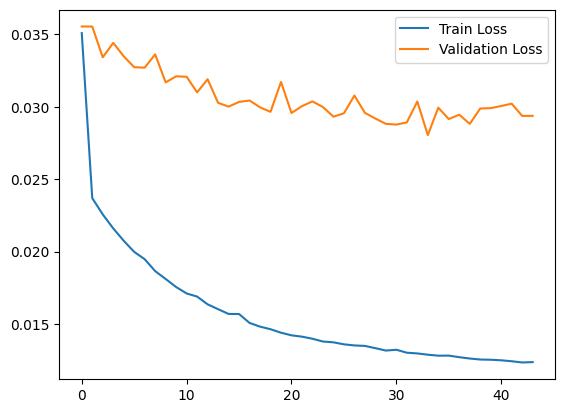

342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
sMAPE for Avg_Temperature: 4.69%
sMAPE for Radiation: 29.19%
sMAPE for Rain_Amount: 12.16%
sMAPE for Wind_Speed: 120.37%
sMAPE for Wind_Direction: 99.60%
Overall sMAPE: 40.75%


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Isitha\\Downloads\\test.csv'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LayerNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load Dataset
df1 = pd.read_csv("cleaned_data.csv")

df1.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)

df = pd.get_dummies(df1, columns=['kingdom'], drop_first=True)

# Define Time Steps
time_steps = 30
X_seq, Y_seq = [], []

# Normalize Features
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Group by Kingdom
for kingdom, group in df1.groupby('kingdom'):
    group_X = df.loc[group.index, ['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
    group_Y = group.loc[:, ["Avg_Temperature","Temperature_Range","Radiation","Rain_Amount","Rain_Duration","Wind_Speed","Wind_Direction","Evapotranspiration"]].values

    group_X = scaler_X.fit_transform(group_X)
    group_Y = scaler_Y.fit_transform(group_Y)

    for i in range(len(group_X) - time_steps):
        X_seq.append(group_X[i:i+time_steps])
        Y_seq.append(group_Y[i+time_steps])

X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)

# Train-Test Split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# Model Architecture
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
    attn_output = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    ff_output = tf.keras.layers.Dense(ff_dim, activation='relu')(attn_output)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)
    return tf.keras.layers.LayerNormalization(epsilon=1e-6)(ff_output + attn_output)

input_layer = Input(shape=(time_steps, X_train.shape[2]))
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(pool1)

lstm = LSTM(64, return_sequences=True)(conv2)
transformer_output = transformer_encoder(lstm, head_size=64, num_heads=8, ff_dim=128)

flatten = Flatten()(transformer_output)
dense1 = Dense(64, activation='relu')(flatten)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(y_train.shape[-1])(dense2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stop])

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Forecasting
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

y_test_original = scaler_Y.inverse_transform(y_test)
y_pred_original = scaler_Y.inverse_transform(model.predict(X_test))

smape_values = [smape(y_test_original[:, i], y_pred_original[:, i]) for i in range(y_test_original.shape[1])]
target_columns = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']
for i, col in enumerate(target_columns):
    print(f"sMAPE for {col}: {smape_values[i]:.2f}%")

print(f"Overall sMAPE: {np.mean(smape_values):.2f}%")


import pandas as pd
import numpy as np

# Load the test dataset
test_df = pd.read_csv("C:\\Users\\Isitha\\Downloads\\test.csv")

# Apply the same preprocessing as the training data
test_df.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)
test_df = pd.get_dummies(test_df, columns=['kingdom'], drop_first=True)

# Ensure all training features exist in test data
missing_cols = set(df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Add missing one-hot encoded columns

# Select feature columns (same as training)
feature_cols = ['Year', 'Month', 'Day'] + [col for col in test_df.columns if 'kingdom' in col]
test_X = test_df[feature_cols].values

# Normalize test data using the same scaler
test_X = scaler_X.transform(test_X)

# Reshape for model input (if sequences are needed)
X_test_seq = []
for i in range(len(test_X) - time_steps):
    X_test_seq.append(test_X[i:i+time_steps])
X_test_seq = np.array(X_test_seq)

# Predict
y_pred_scaled = model.predict(X_test_seq)

# Convert predictions back to original scale
y_pred_original = scaler_Y.inverse_transform(y_pred_scaled)

# Save results to CSV
y_pred_original =pd.DataFrame(y_pred_original)
output_df = pd.DataFrame(y_pred_original)
output_df.to_csv("C:\\Users\\Isitha\\Downloads\\predictions.csv", index=False)

print("Predictions saved successfully!")

In [ ]:
 Save results to CSV
y_pred_original =pd.DataFrame(y_pred_original)
output_df = pd.DataFrame(y_pred_original)
output_df.to_csv("predictions.csv", index=False)

print("Predictions saved successfully!")

Epoch 1/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0520 - mae: 0.1594 - val_loss: 0.0421 - val_mae: 0.1533
Epoch 2/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.0261 - mae: 0.1171 - val_loss: 0.0366 - val_mae: 0.1449
Epoch 3/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 0.0251 - mae: 0.1142 - val_loss: 0.0369 - val_mae: 0.1455
Epoch 4/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0246 - mae: 0.1126 - val_loss: 0.0354 - val_mae: 0.1416
Epoch 5/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0237 - mae: 0.1100 - val_loss: 0.0348 - val_mae: 0.1370
Epoch 6/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0233 - mae: 0.1092 - val_loss: 0.0372 - val_mae: 0.1428
Epoch 7/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0230 - mae: 0.1083 - val_loss: 0.0390 - val_mae: 0.1490
Epoch 8/50
2102/2102 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 0.0223 - mae: 0.1065 - val_loss: 0.0337 - val_mae: 0.1358
Epoch 9/50
2102/2102 ━━━━

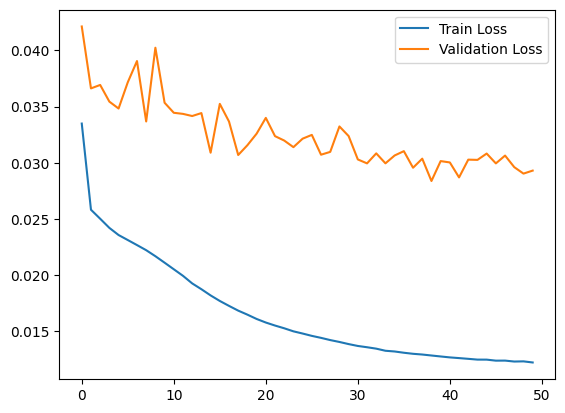

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM,
                                     LayerNormalization, MultiHeadAttention, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# Load Dataset
df1 = pd.read_csv("cleaned_data.csv")
df1.sort_values(by=['kingdom', 'Year', 'Month', 'Day'], ascending=True, inplace=True)
df = pd.get_dummies(df1, columns=['kingdom'], drop_first=True)

time_steps = 30
X_seq, Y_seq = [], []

scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

for kingdom, group in df1.groupby('kingdom'):
    group_X = df.loc[group.index, ['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
    group_Y = group.loc[:, ['Avg_Temperature','Avg_Feels_Like_Temperature','Temperature_Range','Feels_Like_Temperature_Range','Radiation','Rain_Amount,Rain_Duration','Wind_Speed','Wind_Direction','Evapotranspiration']].values

    group_X = scaler_X.fit_transform(group_X)
    group_Y = scaler_Y.fit_transform(group_Y)

    for i in range(len(group_X) - time_steps):
        X_seq.append(group_X[i:i+time_steps])
        Y_seq.append(group_Y[i+time_steps])

X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)

split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout_rate=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    ff_output = Dense(ff_dim, activation='relu')(attn_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    return LayerNormalization(epsilon=1e-6)(ff_output + attn_output)

input_layer = Input(shape=(time_steps, X_train.shape[2]))
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(pool1)

lstm = LSTM(64, return_sequences=True)(conv2)
transformer_output = transformer_encoder(lstm, head_size=64, num_heads=8, ff_dim=128)

flatten = Flatten()(transformer_output)
dense1 = Dense(64, activation='relu')(flatten)
dropout1 = Dropout(0.2)(dense1)
dense2 = Dense(32, activation='relu')(dropout1)
output_layer = Dense(y_train.shape[-1])(dense2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_seq, Y_seq = [], []

for kingdom, group in df1.groupby('kingdom'):
    group_X = df.loc[group.index, ['Year', 'Month', 'Day'] + [col for col in df.columns if 'kingdom' in col]].values
    group_Y = group.loc[:, ['Avg_Temperature', 'Avg_Feels_Like_Temperature', 'Temperature_Range',
                            'Feels_Like_Temperature_Range', 'Radiation', 'Rain_Amount',
                            'Rain_Duration', 'Wind_Speed', 'Wind_Direction', 'Evapotranspiration']].values

    if len(group_X) > 0:  # Avoid empty groups
        scaler_X.fit(group_X)  # Fit only once per group
        scaler_Y.fit(group_Y)  # Ensure scaler_Y is fitted

        group_X = scaler_X.transform(group_X)
        group_Y = scaler_Y.transform(group_Y)

        for i in range(len(group_X) - time_steps):
            X_seq.append(group_X[i:i+time_steps])
            Y_seq.append(group_Y[i+time_steps])

X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)

split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = Y_seq[:split], Y_seq[split:]

# Ensure the scaler is properly fitted before inverse transforming
y_test_original = scaler_Y.inverse_transform(y_test)
y_pred_original = scaler_Y.inverse_transform(model.predict(X_test))
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

smape_values = [smape(y_test_original[:, i], y_pred_original[:, i]) for i in range(y_test_original.shape[1])]

for i, col in enumerate(['Avg_Temperature', 'Avg_Feels_Like_Temperature', 'Temperature_Range',
                            'Feels_Like_Temperature_Range', 'Radiation', 'Rain_Amount',
                            'Rain_Duration', 'Wind_Speed', 'Wind_Direction', 'Evapotranspiration']):
    print(f"sMAPE for {col}: {smape_values[i]:.2f}%")

average_smape = np.mean(smape_values)
print(f"Overall sMAPE: {average_smape:.2f}%")



526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


ValueError: operands could not be broadcast together with shapes (16812,8) (10,) (16812,8) 